<a href="https://colab.research.google.com/github/mamekin05108/signatecup2024summer/blob/main/lightgbm_nocab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import lightgbm as lgb
from sklearn import metrics
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold

# warningsを非表示にする
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/Signate/2024summer/fdata/df_train_allnum.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Signate/2024summer/fdata/df_test_allnum.csv")
ss = pd.read_csv("/content/drive/MyDrive/Signate/2024summer/data/sample_submit.csv", header=None)

In [ ]:
df_train.head()

,id,Age,TypeofContact,DurationOfPitch,Gender,NumberOfPersonVisiting,NumberOfFollowups,NumberOfTrips,Passport,MonthlyIncome,...,PitchSatisfactionScore_5,Designation_AVP,Designation_Executive,Designation_Manager,Designation_Senior Manager,Designation_VP,MaritalStatus_未婚,MaritalStatus_独身,MaritalStatus_結婚,MaritalStatus_離婚
0,0,1.145527e+00,1,0.077180,0,-1.908669,0.361786,1.038068,1,-1.352770,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,1.766003e+00,0,-0.067460,0,-1.908669,0.361786,-0.699052,1,0.639729,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,2,7.347917e-16,1,-0.646021,1,-1.908669,-0.746633,0.459028,0,-1.032001,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3,-1.988390e-01,1,0.511101,1,-1.908669,-0.746633,-1.278092,0,-0.388082,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,4,9.387011e-01,0,0.366461,1,-1.908669,-0.746633,0.459028,0,-1.292825,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
# カラム名の変更マッピング
column_mapping = {
    'Designation_Senior Manager': 'Designation_Senior_Manager'
}
df_train.rename(columns=column_mapping, inplace=True)
df_test.rename(columns=column_mapping, inplace=True)

In [ ]:
rows = []
for col in df_test.columns:
    rows.append([col, df_train[col].dtype, df_train[col].isnull().sum(), len(df_train[col].unique())])
pd.DataFrame(rows, columns=["列名", "列の型", "NaNである行の数", "値の種類"])

,列名,列の型,NaNである行の数,値の種類
0,id,int64,0,3489
1,Age,float64,0,45
2,TypeofContact,int64,0,2
3,DurationOfPitch,float64,0,34
4,Gender,int64,0,2
5,NumberOfPersonVisiting,float64,0,4
6,NumberOfFollowups,float64,0,7
7,NumberOfTrips,float64,0,9
8,Passport,int64,0,2
9,MonthlyIncome,float64,0,2542


In [ ]:
# Config cell
target = "ProdTaken"


cols_category =[]

In [ ]:
rows = []
for col in df_train.columns:
    rows.append([col, df_train[col].dtype, df_train[col].isnull().sum(), len(df_train[col].unique())])
pd.DataFrame(rows, columns=["列名", "列の型", "NaNである行の数", "値の種類"])

,列名,列の型,NaNである行の数,値の種類
0,id,int64,0,3489
1,Age,float64,0,45
2,TypeofContact,int64,0,2
3,DurationOfPitch,float64,0,34
4,Gender,int64,0,2
5,NumberOfPersonVisiting,float64,0,4
6,NumberOfFollowups,float64,0,7
7,NumberOfTrips,float64,0,9
8,Passport,int64,0,2
9,MonthlyIncome,float64,0,2542


In [ ]:
#df_train.drop(["id"], axis=1, inplace=True)
#df_test.drop(["id"], axis=1, inplace=True)

In [ ]:
train_y = df_train[target]
train_x = df_train.drop(target, axis=1)

In [ ]:
#df_train.to_csv("/content/drive/MyDrive/Signate/2024summer/dft_train.csv", index=False)
#df_test.to_csv("/content/drive/MyDrive/Signate/2024summer/dft_test.csv", index=False)

In [ ]:
params_lgb = {
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 20,
    'feature_fraction': 0.4,
    'bagging_fraction': 0.8,
    'bagging_freq': 3,
    'verbose': -1,
    'lambda_l1': 0.80,
    'lambda_l2': 90,
    "n_estimators": 3000,
    "learning_rate": 0.01,
    "subsample_freq": 1,
    "subsample": 0.8,
    "random_seed": 0,
}

In [ ]:
# f1スコアが最も高くなる点を見つける
from sklearn import metrics
def decide_cutoff(val_y, preds_y_proba):
    mean_f1_list = []
    fpr, tpr, thresholds = metrics.roc_curve(val_y, preds_y_proba)
    for threshold in thresholds:
        preds_y = [1 if prob > threshold else 0 for prob in preds_y_proba]
        #preds_y=preds_y_proba
        mean_f1_list.append(f1_score(val_y, preds_y, average='macro'))
    return np.max(mean_f1_list), thresholds[np.argmax(mean_f1_list)]

In [ ]:
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import roc_auc_score


In [ ]:
list_metrics_auc = []
list_metrics_f1 = []
list_cutoff = []
list_models = []
fraction_of_positives_list = []
mean_predicted_value_list = []

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
for fold, (trn_idx, val_idx) in enumerate(cv.split(train_x, train_y), start=0):
    trn_x = train_x.iloc[trn_idx, :]
    trn_y = train_y[trn_idx]
    val_x = train_x.iloc[val_idx, :]
    val_y = train_y[val_idx]
    model_lgb = lgb.LGBMClassifier(**params_lgb)
    model_lgb.fit(
        trn_x, trn_y,
        eval_set=(val_x, val_y),
        callbacks=[lgb.early_stopping(100, verbose=True)],
        categorical_feature=cols_category,
    )
    list_models.append(model_lgb)
    preds_y_proba = model_lgb.predict_proba(val_x)[:, 1]
    auc = roc_auc_score(val_y, preds_y_proba)
    f1, threshold = decide_cutoff(val_y, preds_y_proba)
    list_metrics_auc.append(auc)
    list_metrics_f1.append(f1)
    list_cutoff.append(threshold)
    print(f"Fold: {fold}, AUC: {auc}, f1 score: {f1} Threshold: {threshold}")

        # キャリブレーション曲線を計算
    fraction_of_positives, mean_predicted_value = calibration_curve(val_y, preds_y_proba, n_bins=10)
    fraction_of_positives_list.append(fraction_of_positives)
    mean_predicted_value_list.append(mean_predicted_value)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1569]	valid_0's auc: 0.86118
Fold: 0, AUC: 0.8611799253181229, f1 score: 0.7407246614882782 Threshold: 0.27707143813094076
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1624]	valid_0's auc: 0.825936
Fold: 1, AUC: 0.8259356382400213, f1 score: 0.7155857027016591 Threshold: 0.313978468563717
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1308]	valid_0's auc: 0.833783
Fold: 2, AUC: 0.8337827169490495, f1 score: 0.7144553454640479 Threshold: 0.25925837819458586


In [ ]:
# AUC
print(np.mean(list_metrics_auc), np.mean(list_metrics_f1), np.median(list_cutoff))

0.8402994268357311 0.7235885698846617 0.27707143813094076


0.8373282614250895 0.722482118955046 0.24324288593076013


In [ ]:
# AUC
print(np.mean(list_metrics_auc), np.mean(list_metrics_f1), np.median(list_cutoff))

0.840365682272048 0.7280014830847816 0.30771136179129044


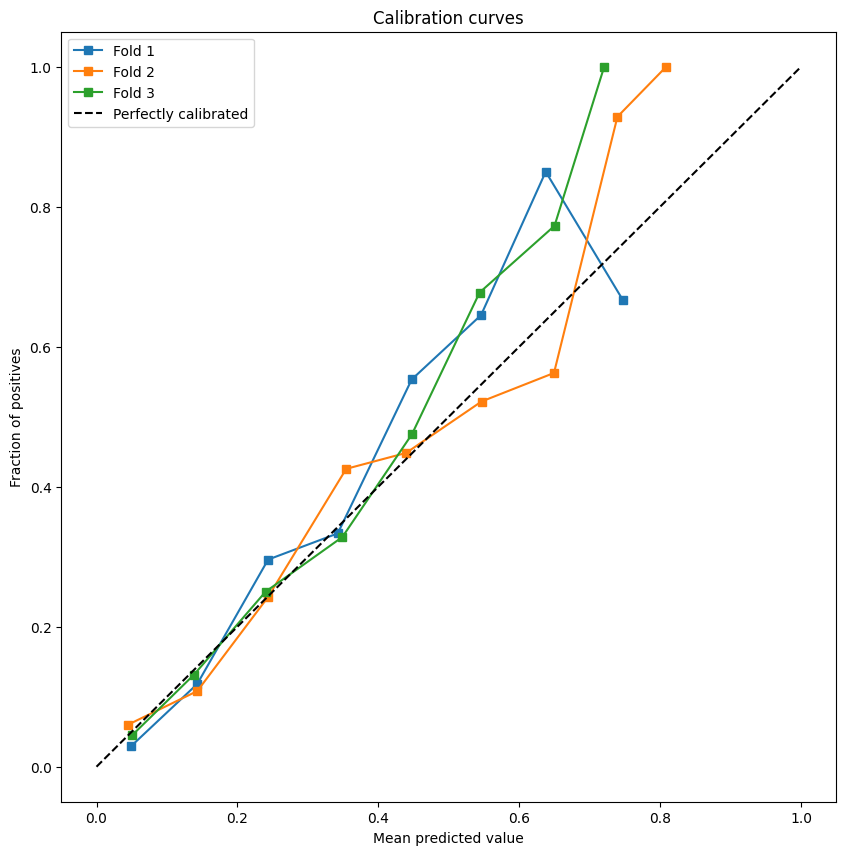

In [ ]:
# キャリブレーション曲線の描画
plt.figure(figsize=(10, 10))
for i in range(cv.n_splits):
    plt.plot(mean_predicted_value_list[i], fraction_of_positives_list[i], "s-", label=f"Fold {i+1}")

plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.xlabel("Mean predicted value")
plt.ylabel("Fraction of positives")
plt.title("Calibration curves")
plt.legend()
plt.show()

In [ ]:
threshold = np.median(list_cutoff)

In [ ]:
df_train.head()

,id,Age,TypeofContact,DurationOfPitch,Gender,NumberOfPersonVisiting,NumberOfFollowups,NumberOfTrips,Passport,MonthlyIncome,...,PitchSatisfactionScore_5,Designation_AVP,Designation_Executive,Designation_Manager,Designation_Senior_Manager,Designation_VP,MaritalStatus_未婚,MaritalStatus_独身,MaritalStatus_結婚,MaritalStatus_離婚
0,0,1.145527e+00,1,0.077180,0,-1.908669,0.361786,1.038068,1,-1.352770,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1,1.766003e+00,0,-0.067460,0,-1.908669,0.361786,-0.699052,1,0.639729,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,2,7.347917e-16,1,-0.646021,1,-1.908669,-0.746633,0.459028,0,-1.032001,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3,-1.988390e-01,1,0.511101,1,-1.908669,-0.746633,-1.278092,0,-0.388082,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,4,9.387011e-01,0,0.366461,1,-1.908669,-0.746633,0.459028,0,-1.292825,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
df_test.head()


,id,Age,TypeofContact,DurationOfPitch,Gender,NumberOfPersonVisiting,NumberOfFollowups,NumberOfTrips,Passport,MonthlyIncome,...,PitchSatisfactionScore_5,Designation_AVP,Designation_Executive,Designation_Manager,Designation_Senior_Manager,Designation_VP,MaritalStatus_未婚,MaritalStatus_独身,MaritalStatus_結婚,MaritalStatus_離婚
0,3489,0.938701,1,-0.212100,0,-1.908669,0.361786,2.196148,0,1.863454,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,3490,-0.922728,1,-0.356740,1,-1.908669,0.361786,0.459028,1,-0.742793,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,3491,-1.439792,1,-0.790661,1,-1.908669,0.361786,-1.278092,0,-1.272115,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3492,-1.853443,0,-1.079941,0,-1.908669,0.361786,-1.278092,0,-1.273769,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,3493,0.214812,0,-1.079941,0,-1.908669,0.361786,-1.278092,0,-1.155267,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


0.8230385101796399 0.7189891651655609 0.2949468672477912


In [ ]:
threshold = np.median(list_cutoff)
preds_y_proba = np.zeros(len(df_test))
for model in list_models:
    preds_y_proba += model.predict_proba(df_test[model.feature_name_])[:, 1] / len(list_models)
    print(f"Model: {model}, Proba: {preds_y_proba}")  # 予測確率を表示
preds_y = preds_y_proba

Model: LGBMClassifier(bagging_fraction=0.8, bagging_freq=3, feature_fraction=0.4,
               lambda_l1=0.8, lambda_l2=90, learning_rate=0.01, metric='auc',
               n_estimators=3000, num_leaves=20, objective='binary',
               random_seed=0, subsample=0.8, subsample_freq=1, verbose=-1), Proba: [0.03763586 0.07860302 0.06876327 ... 0.17751494 0.07273608 0.00786301]
Model: LGBMClassifier(bagging_fraction=0.8, bagging_freq=3, feature_fraction=0.4,
               lambda_l1=0.8, lambda_l2=90, learning_rate=0.01, metric='auc',
               n_estimators=3000, num_leaves=20, objective='binary',
               random_seed=0, subsample=0.8, subsample_freq=1, verbose=-1), Proba: [0.0672236  0.14774703 0.16461337 ... 0.37489072 0.14533384 0.01318641]
Model: LGBMClassifier(bagging_fraction=0.8, bagging_freq=3, feature_fraction=0.4,
               lambda_l1=0.8, lambda_l2=90, learning_rate=0.01, metric='auc',
               n_estimators=3000, num_leaves=20, objective='binary',
   

In [ ]:
count = 0

In [ ]:
from datetime import datetime
import pytz
# カウント変数をインクリメント
count += 1
# 日本時間を取得
japan_tz = pytz.timezone('Asia/Tokyo')
now = datetime.now(japan_tz)
timestamp = now.strftime("%Y%m%d_%H%M%S")

file_name = f"/content/drive/MyDrive/Signate/2024summer/simplelightgbm_{timestamp}_{count:03d}.csv"
ss[1] = preds_y
ss.to_csv(file_name, header=False, index=False)